In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier

pd.set_option('display.max_columns', None)

id: A unique identifier for each entry.

Gender: The gender of the participant (Male/Female).

Age: The age of the participant.

Height: The height of the participant in meters.

Weight: The weight of the participant in kilograms.

family_history_with_overweight: Whether there is a family history of overweight (yes/no).

FAVC: Frequent consumption of high caloric food (yes/no).

FCVC: Frequency of consumption of vegetables (numerical).

NCP: Number of main meals (numerical).

CAEC: Consumption of food between meals (Sometimes/Frequently/Always/No).

SMOKE: Smoking status (yes/no).

CH2O: Daily water drinking (numerical, presumably in liters).

SCC: Calories consumption monitoring (yes/no).

FAF: Physical activity frequency (numerical).

TUE: Time using technology devices (numerical).

CALC: Consumption of alcohol (Sometimes/Frequently/Always/No).

MTRANS: Main transportation mode (various categories).

NObeyesdad: Obesity level, the target variable with categorical values indicating different levels of obesity.

In [2]:
train = pd.read_csv("inputs/train.csv")

train['Gender'] = train['Gender'].map({'Female':1, 'Male':0})
train['family_history_with_overweight'] = train['family_history_with_overweight'].map({'yes':1, 'no':0})
train['FAVC'] = train['FAVC'].map({'yes':1, 'no':0})
train['SMOKE'] = train['SMOKE'].map({'yes':1, 'no':0})
train['SCC'] = train['SCC'].map({'yes':1, 'no':0})
train['CAEC'] = train['CAEC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})
train['CALC'] = train['CALC'].map({'no':0, 'Sometimes':1, 'Frequently':2})

train = pd.get_dummies(train, columns=['MTRANS'])

In [3]:
train['NObeyesdad'].value_counts(1)

NObeyesdad
Obesity_Type_III       0.194913
Obesity_Type_II        0.156470
Normal_Weight          0.148473
Obesity_Type_I         0.140187
Insufficient_Weight    0.121544
Overweight_Level_II    0.121495
Overweight_Level_I     0.116919
Name: proportion, dtype: float64

In [4]:
(
    train
    .groupby('NObeyesdad', as_index=False)
    .agg({
        'Gender': ['mean', 'std'],
        'Age': ['mean', 'std'],
        'Height': ['mean', 'std'],
        'Weight': ['mean', 'std'],
        'family_history_with_overweight': ['mean', 'std'],
        'FAVC': ['mean', 'std'],
        'FCVC': ['mean', 'std'],
        'NCP': ['mean', 'std'],
        'SMOKE': ['mean', 'std'],
        'CH2O': ['mean', 'std'],
        'SCC': ['mean', 'std'],
        'FAF': ['mean', 'std'],
        'TUE': ['mean', 'std'],
        'CAEC': ['mean', 'std'],
        'CALC': ['mean', 'std']
    })
    .round(3)
)

NObeyesdad Gender            Age        Height          Weight  \
                         mean    std    mean    std   mean    std     mean   
0  Insufficient_Weight  0.642  0.479  19.337  2.249  1.684  0.096   49.861   
1        Normal_Weight  0.539  0.499  20.801  3.420  1.671  0.087   61.533   
2       Obesity_Type_I  0.435  0.496  25.024  7.240  1.694  0.090   92.371   
3      Obesity_Type_II  0.002  0.050  27.707  4.275  1.783  0.064  115.996   
4     Obesity_Type_III  0.999  0.035  24.127  2.576  1.676  0.059  117.697   
5   Overweight_Level_I  0.441  0.497  23.045  5.935  1.687  0.085   74.228   
6  Overweight_Level_II  0.299  0.458  26.032  7.776  1.706  0.074   82.086   

          family_history_with_overweight          FAVC          FCVC         \
      std                           mean    std   mean    std   mean    std   
0   5.735                          0.426  0.495  0.853  0.354  2.480  0.584   
1   8.525                          0.581  0.494  0.839  0.367  2.372  0.544   
2  11.425                          0.984  0.127  0.968  0.176  2.097  0.391   
3   7.803                          0.998  0.039  0.983  0.128  2.425  0.490   
4  13.341                          1.000  0.016  1.000  0.016  3.000  0.000   
5   7.997                          0.689  0.463  0.908  0.290  2.257  0.489   
6   7.403                          0.923  0.266  0.786  0.410  2.224  0.444   

     NCP         SMOKE          CH2O           SCC           FAF         \
    mean    std   mean    std   mean    std   mean    std   mean    std   
0  2.920  0.865  0.003  0.053  1.744  0.560  0.092  0.289  1.202  0.845   
1  2.890  0.663  0.015  0.121  1.806  0.557  0.052  0.222  1.190  0.906   
2  2.455  0.831  0.008  0.090  2.130  0.629  0.006  0.078  0.923  0.927   
3  2.798  0.492  0.035  0.184  1.985  0.552  0.001  0.035  1.030  0.546   
4  3.000  0.003  0.001  0.031  2.332  0.578  0.000  0.000  0.549  0.729   
5  2.528  0.922  0.010  0.101  2.069  0.625  0.103  0.303  1.135  0.862   
6  2.594  0.745  0.010  0.099  2.004  0.537  0.010  0.097  1.061  0.829   

     TUE          CAEC          CALC         
    mean    std   mean    std   mean    std  
0  0.803  0.659  1.505  0.533  0.653  0.488  
1  0.630  0.620  1.396  0.664  0.674  0.514  
2  0.739  0.735  1.060  0.326  0.548  0.548  
3  0.416  0.533  1.009  0.129  0.863  0.355  
4  0.549  0.295  1.001  0.042  1.000  0.000  
5  0.557  0.661  1.072  0.545  0.915  0.430  
6  0.698  0.641  1.107  0.356  0.688  0.629

# Modelos

In [5]:
lbl_enc = LabelEncoder()
train['NObeyesdad'] = lbl_enc.fit_transform(train['NObeyesdad'])

In [6]:
X = train.drop('NObeyesdad', axis=1)
y = train['NObeyesdad'].copy()

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

resultados = {
    'Random Forest': [],
    'XGBoost': []
}

fold = 0
for treino, valid in kf.split(X, y):
    print(f"Iniciando fold n.: {fold + 1}")
    fold += 1
    X_treino, X_valid = X.iloc[treino], X.iloc[valid]
    y_treino, y_valid = y.iloc[treino], y.iloc[valid]

    baseline_rfc = RandomForestClassifier(n_jobs=-1)
    baseline_rfc.fit(X_treino, y_treino)
    baseline_rfc_preds = baseline_rfc.predict(X_valid)
    resultados['Random Forest'].append(accuracy_score(y_valid, baseline_rfc_preds))

    baseline_xgb = XGBClassifier(objective='multi:softmax')
    baseline_xgb.fit(X_treino, y_treino)
    baseline_xgb_preds = baseline_xgb.predict(X_valid)
    resultados['XGBoost'].append(accuracy_score(y_valid, baseline_xgb_preds))

Iniciando fold n.: 1
Iniciando fold n.: 2
Iniciando fold n.: 3
Iniciando fold n.: 4
Iniciando fold n.: 5


In [7]:
# test preds and submission

test = pd.read_csv('inputs/test.csv')
test['Gender'] = test['Gender'].map({'Female':1, 'Male':0})
test['family_history_with_overweight'] = test['family_history_with_overweight'].map({'yes':1, 'no':0})
test['FAVC'] = test['FAVC'].map({'yes':1, 'no':0})
test['SMOKE'] = test['SMOKE'].map({'yes':1, 'no':0})
test['SCC'] = test['SCC'].map({'yes':1, 'no':0})
test['CAEC'] = test['CAEC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})
test['CALC'] = test['CALC'].map({'no':0, 'Sometimes':1, 'Frequently':2})
test['CALC'] = test['CALC'].fillna(test['CALC'].mean())

test = pd.get_dummies(test, columns=['MTRANS'])

preds = baseline_xgb.predict(test)
sub = test[['id']].copy()
sub['NObeyesdad'] = preds
sub['NObeyesdad'] = lbl_enc.inverse_transform(sub['NObeyesdad'])

sub.to_csv("submission.csv", index=False)

In [8]:
pd.DataFrame(resultados).mean()

Random Forest    0.896907
XGBoost          0.903844
dtype: float64

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

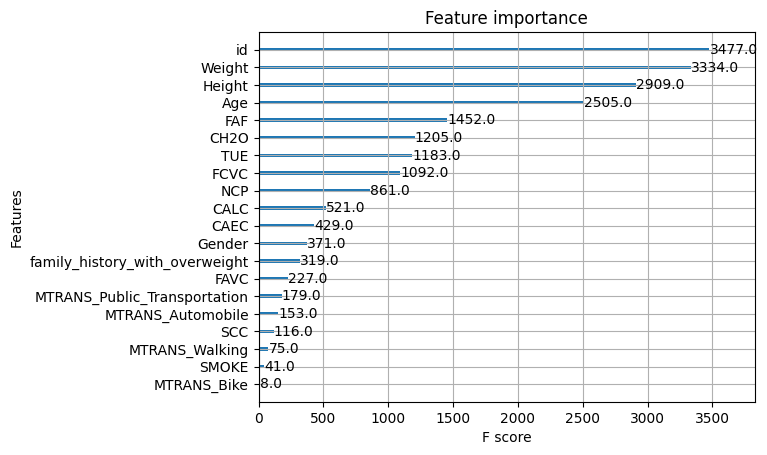

In [9]:
from xgboost import plot_importance
plot_importance(baseline_xgb)